---
#### *Introduction*
In this notebook, we aim to analyze the robustness and interpretability of our pre-trained coin classification model when faced with masked images. Specifically, we will investigate how the model performs when the central part of each coin image is removed.

The key steps in this notebook include:

1. **Replicate the Model Architecture**: We will replicate the architecture of our previously trained model to ensure consistency in our experiments.
2. **Prepare Masked Images**: Ten images from each class will be selected randomly from the test and the central portion of these images will be removed.
3. **Evaluate Model Performance**: The masked images will be tested with the model to evaluate its classification performance on these altered images.
4. **Apply Grad-CAM**: Grad-CAM will be utilized to visualize the regions of the masked images that the model focuses on when making its predictions.

Through this experiment, we aim to:
- Assess the impact of central masking on the model's classification accuracy.
- Understand the model's reliance on specific features of the coin images.
- Gain insights into the model's decision-making process by visualizing Grad-CAM heatmaps.

---

In [47]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils import normalize
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import random

In [48]:
data_path = r"Combined_images"

file_names = []

# Iterate over each file in the specified directory
for filename in os.listdir(data_path):
    if filename.endswith(('.jpg', '.png', '.tif', '.JPG')):
        file_names.append(filename)

In [49]:
# Function to extract the number from the image filename
def extract_number_from_filename(filename):
    return filename.split('_')[1].split('.')[0]


clean_file_names = []

for name in file_names:
    clean_file_names.append(extract_number_from_filename(name))
    

image_names = clean_file_names

# Function to read the CSV and create a dictionary of image names to labels
def read_csv_to_dict(csv_file):
    df = pd.read_csv(csv_file)

    # Extract image names and labels
    image_names = df.iloc[:, 0].values
    labels = df.iloc[:, -1].values

    # Create a list of image-label pairs
    image_label_array = np.array([[name, label] for name, label in zip(image_names, labels)])
    
    # Convert the NumPy array to a dictionary
    image_label_dict = {row[0]: row[1] for row in image_label_array}
    return image_label_dict

# Main execution
csv_file_path = 'image_labels.csv'
image_label_dict = read_csv_to_dict(csv_file_path)

In [50]:
data_path = 'Combined_images'

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = load_img(file_path)
    img_array = img_to_array(img)
    return img_array

# Search for image files and load images and labels
images = []
image_labels = []
for key, label in image_label_dict.items():
    found = False
    for root, _, files in os.walk(data_path):
        for file in files:
            if key in file and (label == 'Misr' or label == 'al-Mansuriyah'):
                file_path = os.path.join(root, file)
                img_array = load_and_preprocess_image(file_path)
                images.append(img_array)
                image_labels.append(label)
                found = True
                break
        if found:
            break

# Convert to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Encode labels as integers
label_to_index = {label: idx for idx, label in enumerate(np.unique(image_labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
image_labels = np.array([label_to_index[label] for label in image_labels])

# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42, stratify=image_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

In [52]:
# Function to extract 10 images per class from the test set
def extract_and_save_images_for_modification(images, labels, index_to_label, save_dir, num_per_class=10):
    random.seed(42)
    class_indices = {}
    for idx, label in enumerate(labels):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)

    selected_indices = [] 
    
    for label, indices in class_indices.items():
        selected_indices = random.sample(indices, min(num_per_class, len(indices)))
         # Create directory for saving images if it doesn't exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir, exist_ok=True)
        else:
            print(f"Directory '{save_dir}' already exists. Aborting.")
            return selected_indices

        label_dir = os.path.join(save_dir, index_to_label[label])
        
        os.makedirs(label_dir, exist_ok=True)

        for idx in selected_indices:
            img_array = images[idx]
            img_name = f"{index_to_label[label]}_{idx}.jpg"
            img_path = os.path.join(label_dir, img_name)
            # Convert image array back to image and save
            img = np.clip(img_array, 0, 255).astype(np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR for saving with cv2
            cv2.imwrite(img_path, img)
            
    return selected_indices
        
    
# Save 10 images per class from the test set for manual modification
save_dir = 'images_for_modification'
selected_indices = extract_and_save_images_for_modification(X_test, y_test, index_to_label, save_dir, num_per_class=10)
print("Images saved for manual modification.")

# remove all the selected images from the test set
X_test = np.delete(X_test, selected_indices, axis=0)
y_test = np.delete(y_test, selected_indices, axis=0)     

Directory 'images_for_modification' already exists. Aborting.
Images saved for manual modification.


In [53]:
# Function to load manually modified images
def load_modified_images(modified_dir, target_size=(224, 224)):
    modified_images = []
    modified_labels = []
    for class_name in os.listdir(modified_dir):
        class_dir = os.path.join(modified_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img_array = load_and_preprocess_image(img_path)
            modified_images.append(img_array)
            modified_labels.append(label_to_index[class_name])
    return np.array(modified_images), np.array(modified_labels)

# Directory containing manually modified images
modified_images_dir = 'modified_images' 

# Load manually modified images
modified_images, modified_labels = load_modified_images(modified_images_dir)
print(f"Loaded {len(modified_images)} modified images.")

Loaded 20 modified images.


In [54]:
# Combine original and modified images into one test set
combined_test_images = np.concatenate((X_test, modified_images))
combined_test_labels = np.concatenate((y_test, modified_labels))

print(f"Combined test set size: {len(combined_test_images)}")

Combined test set size: 99


In [55]:
# Resize images to 224x224
X_train_resized = tf.image.resize(X_train, (224, 224))
X_val_resized = tf.image.resize(X_val, (224, 224))
X_test_resized = tf.image.resize(combined_test_images, (224, 224))

# Preprocess images
X_train = preprocess_input(X_train_resized)
X_val = preprocess_input(X_val_resized)
X_test = preprocess_input(X_test_resized)

In [56]:
# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_index))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(label_to_index))
y_test = tf.keras.utils.to_categorical(combined_test_labels, num_classes=len(label_to_index))

In [58]:
# Load pre-trained VGG16 model + higher level layers
def create_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add custom top layers for transfer learning
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Combine base model and new top layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model (not trainable)
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Load the model with the same architecture as the previous one
num_classes = 2
model = create_model(num_classes)
model.load_weights('fine_tuned_vgg16.h5')

In [59]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Evaluate model performance on the combined test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.8788


In [68]:
unique_labels, counts = np.unique(y_test, return_counts=True)
print(unique_labels , counts)

[0. 1.] [99 99]


In [61]:
# Load and preprocess the image
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Display the heatmap
def display_heatmap(heatmap):
    plt.figure(figsize=(3, 3))
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')
    plt.show()

# Superimpose the Grad-CAM heatmap on the original image
def superimpose_heatmap_on_image(img_path, heatmap):
    plt.figure(figsize=(6, 6))
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Post-processing techniques
def apply_post_processing(heatmap, method='gaussian'):
    if method == 'gaussian':
        heatmap = cv2.GaussianBlur(heatmap, (15, 15), 0)
    elif method == 'threshold':
        _, heatmap = cv2.threshold(heatmap, 0.5, 1.0, cv2.THRESH_BINARY)
    return heatmap

# Generate Grad-CAM heatmap with different techniques
def generate_gradcam_heatmap(model, img_array, penultimate_layer='block5_conv3', clone=False):
    # Predict the class of the image
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Define the score for the target class
    score = CategoricalScore([predicted_class])

    # Generate heatmap
    gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=clone)
    heatmap = gradcam(score, img_array, penultimate_layer=penultimate_layer)
    
    # Normalize the heatmap to keep it in the [0,1] range
    heatmap = normalize(heatmap)
    heatmap = heatmap[0]  # Extract the heatmap for further processing

    # Apply post-processing
    heatmap = apply_post_processing(heatmap)

    # Display heatmap
    # display_heatmap(heatmap)

    return heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
[[1. 0.]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


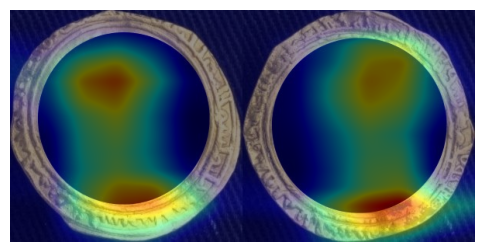

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
[[1.0000000e+00 5.9440664e-32]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


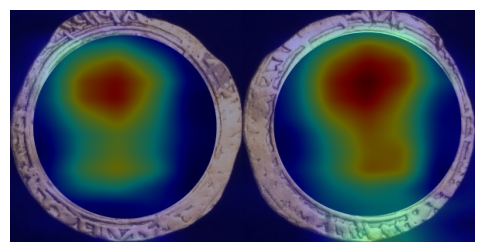

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
[[1.0000000e+00 2.0993491e-29]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


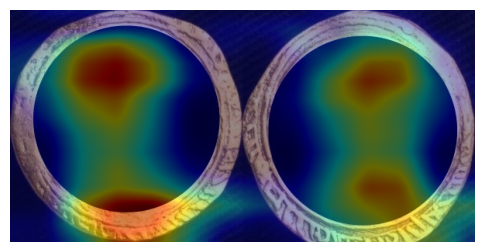

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
[[1.000000e+00 9.927115e-36]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


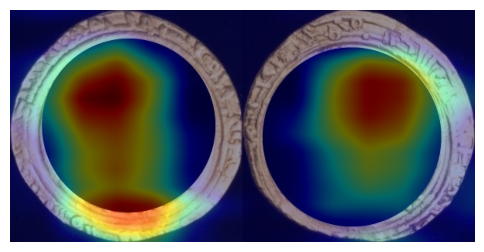

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
[[1. 0.]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


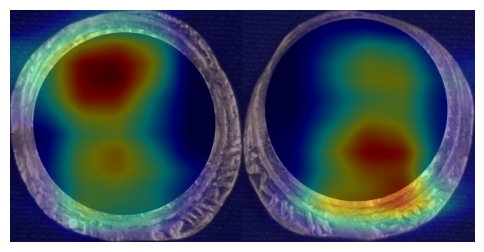

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[[1.000000e+00 1.072492e-37]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


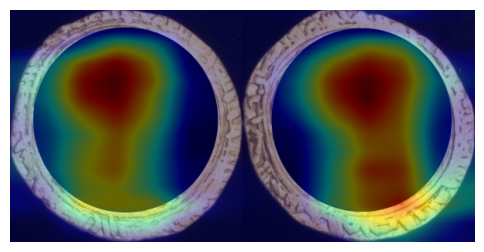

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
[[1.0000000e+00 3.0088294e-38]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


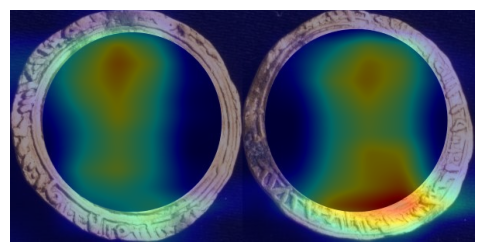

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
[[1. 0.]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


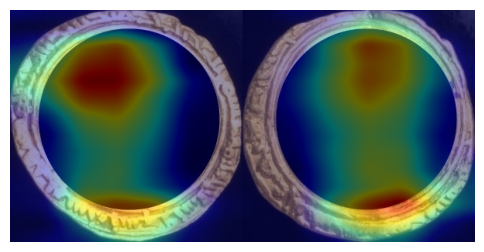

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
[[1.0000000e+00 2.1924274e-34]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


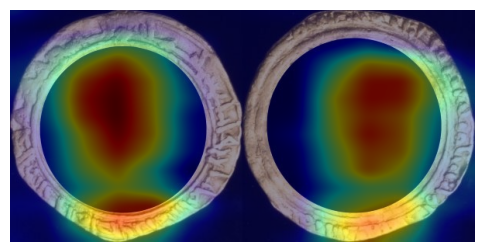

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
[[1. 0.]]
True class: al-Mansuriyah
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


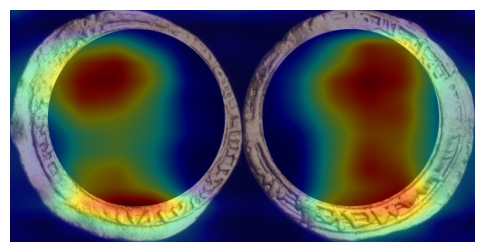

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


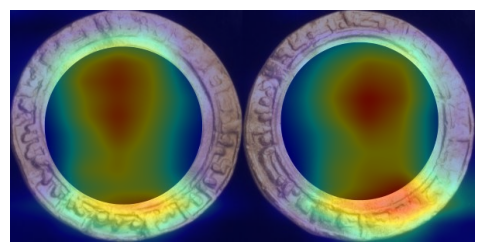

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


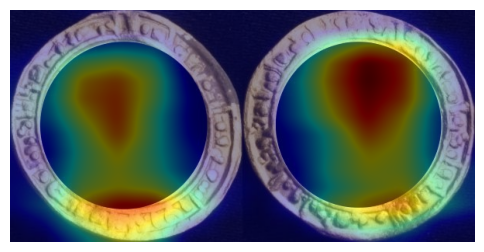

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


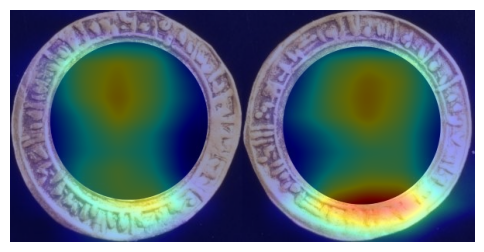

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


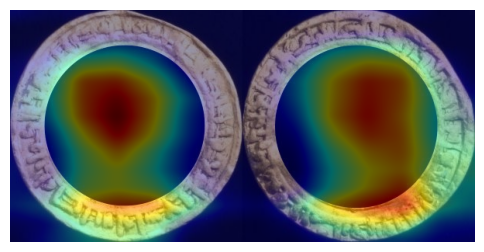

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


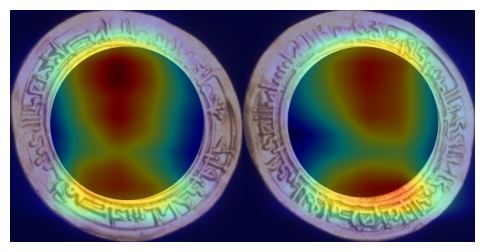

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


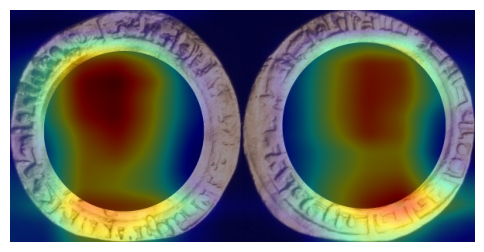

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


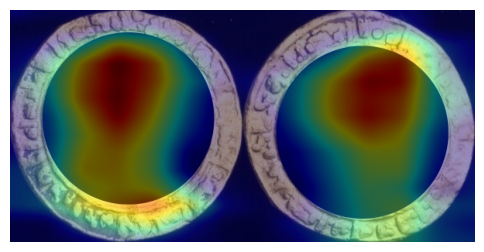

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


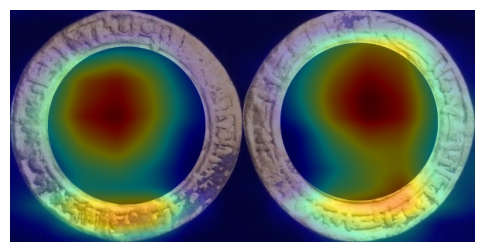

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


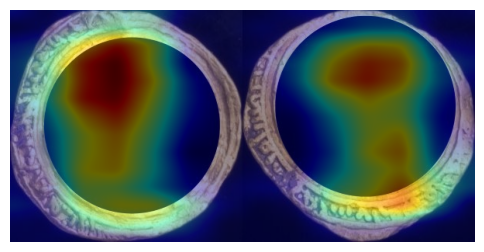

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
[[1. 0.]]
True class: Misr
Predicted class: Misr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


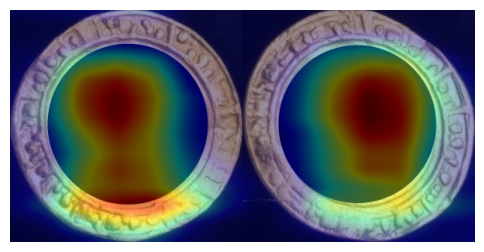

In [62]:
for class_dir in os.listdir(modified_images_dir):
    for img_file in os.listdir(os.path.join(modified_images_dir, class_dir)):
        img_path = os.path.join(modified_images_dir, class_dir, img_file)
        img_array = load_and_preprocess_image(img_path)
        predictions = model.predict(img_array)
        print(predictions)
        predicted_class = np.argmax(predictions)
        true_class = class_dir
        print(f"True class: {true_class}")
        print(f"Predicted class: {index_to_label[predicted_class]}")
        heatmap = generate_gradcam_heatmap(model, img_array, penultimate_layer='block5_conv3', clone=False)
        superimpose_heatmap_on_image(img_path, heatmap)